## Credit Card Customer Segmentation Case Study

### Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 

### Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

### Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Importing necessary libraries

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans, DBSCAN


# import silhouette metrics
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
#remove warnings

import warnings

warnings.filterwarnings('ignore')

## Reading the Dataset

In [3]:
# loading the dataset

df = pd.read_excel("Credit+Card+Customer+Data.xlsx")

### Checking the shape of the dataset

In [4]:
# checking the dimension of the data 

df.shape

(660, 7)

* The dataset has 660 rows and 7 columns 

### Viewing a random sample of the dataset

In [5]:
# viewing a random sample of the dataset

df.sample(5)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
619,620,47650,158000,7,0,13,0
252,253,33457,9000,4,5,0,4
225,226,61234,16000,4,1,2,5
529,530,43679,34000,6,3,2,4
365,366,22348,13000,7,5,0,2


### Replacing all the spaces in our column names

In [6]:
# Putting an underscore in between all the spaces in our column names

df.columns = df.columns.str.replace(" ", "_")

In [7]:
df.columns

Index(['Sl_No', 'Customer_Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'],
      dtype='object')

Here are the 7 column names in our dataset

### Making a copy our dataset

In [8]:
# copying the data to another variable to avoid any changes to original data

data = df.copy()

In [9]:
# dropping the serial no. and customer key columns as they do not provide any information

data.drop(["Sl_No", "Customer_Key"], axis = 1, inplace=True)

In [10]:
# Sanity Check

data.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


### Checking the data types of the columns for the dataset

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


**Observations**

- All the variables are of type *int* (integer).

### Checking for missing values

In [12]:
# checking for missing values

data.isnull().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

- There are no missing values in our data

### Statistical summary of the dataset

In [13]:
data.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000
mean,34574.242424,4.706061,2.403030,2.606061,3.583333
std,37625.487804,2.167835,1.631813,2.935724,2.865317
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,48000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


**Observations**

- The median value of average credit limit is 18000 and the maximum average card limit is 200,000. The mean is 34574


- The average total number of credit cards possessed by a customer 4 and the maximum is 10


- The maximum total visits to the bank is 5 with an average of 2.4. This means that most customers didn't visit the bank more than 2 times yearly


- The average of total visits online is 2.6 and the median is 2. This means that half of the customers in our data have loggedin online at least twice a year


- The maximum total number of calls made by the customer to the bank or its customer service department (yearly) is 10 and the median is 3.
 

### Checking for duplicates

In [14]:
# Checking for duplicate observations

data.duplicated().sum()

11

- There are 11 duplicate observations. We will remove them from the data.

In [15]:
# rowss of data with duplicates

data[data.duplicated() == True]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
162,8000,2,0,3,4
175,6000,1,0,2,5
215,8000,4,0,4,7
295,10000,6,4,2,3
324,9000,4,5,0,4
361,18000,6,3,1,4
378,12000,6,5,2,1
385,8000,7,4,2,0
395,5000,4,5,0,1
455,47000,6,2,0,4


In [16]:
# drop the duplicates

data.drop_duplicates(inplace = True)

data.reset_index(drop = True, inplace = True)

In [17]:
# Sanity check

data.duplicated().sum()

0

There are no duplicates in our dataset

### Exploratory Data Analysis

In [18]:
from utils import labeled_barplot, histogram_boxplot

### Univariate Analysis

In [19]:
# select the numerical features as a list of numerical columns
num_col = data.drop("Avg_Credit_Limit", axis=1).columns.tolist()

print(num_col)


['Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']


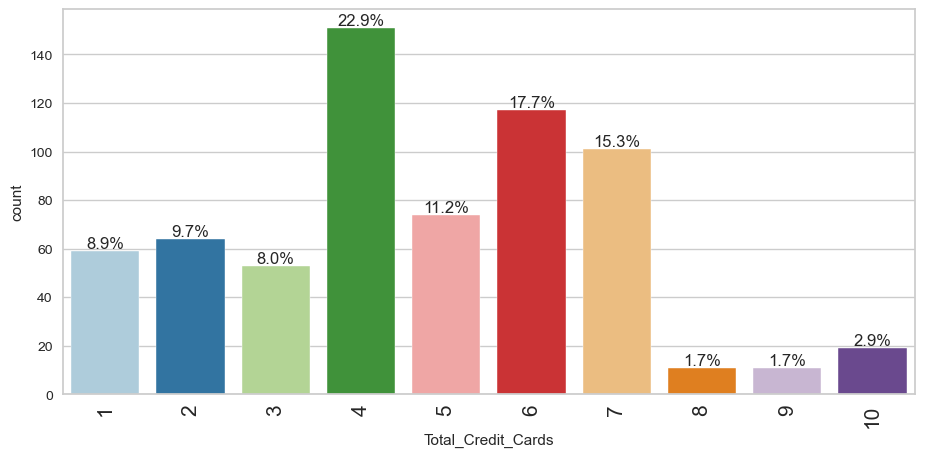

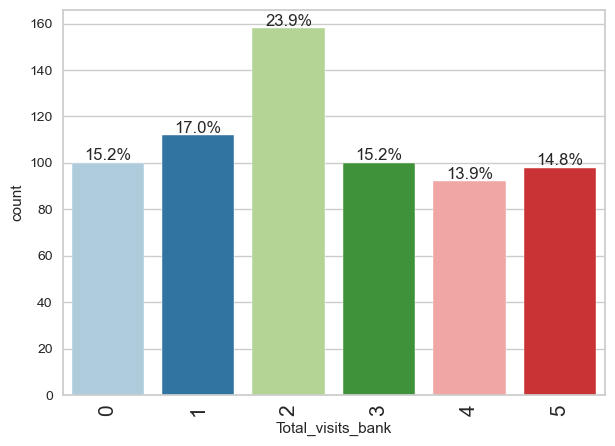

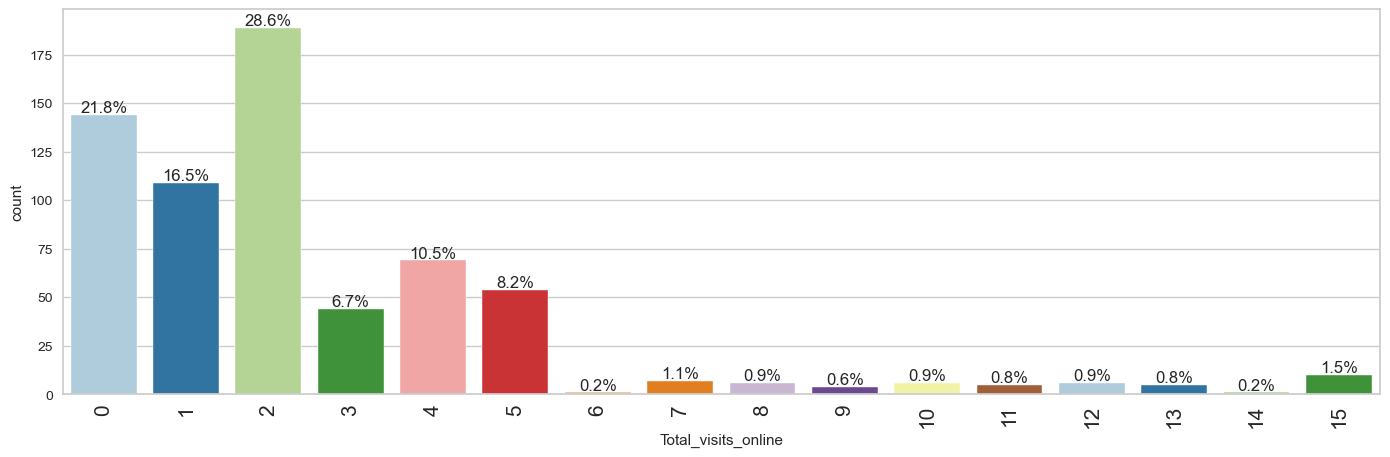

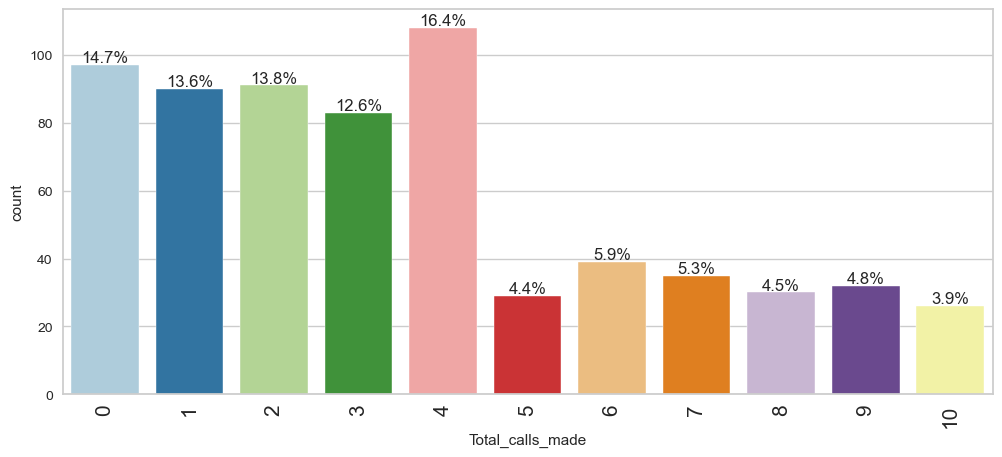

In [20]:
# loop through each column and create a bar plot for each feature

for col in num_col:
    labeled_barplot(data = df, feature=col, perc=True)

***Observations***

- 67.1% of customers in this bank have between 4 to 7 credit cards, and 26.6% have between 1 to 3 credit cards.


- Among the customers in our data, 15.2% have never visited the bank, while the largest number of visits is 2, comprising 23.9% of the total visits.


- Approximately 21.8% of customers have never logged in online, while over 16% have logged in online more than 5 times in a year.


- The highest number of calls made by a customer to the bank or its customer service department (yearly) is 4, which accounts for 16.4% of the total calls.

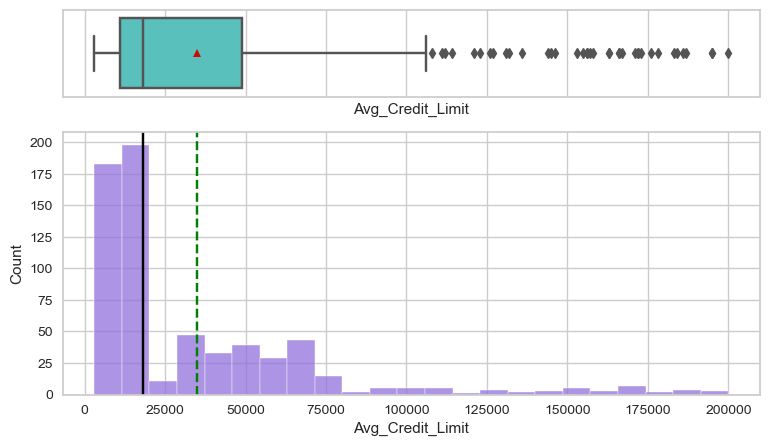

In [21]:
# Histogram and boxplot for the Average Credit Limit

histogram_boxplot(data = data, feature = "Avg_Credit_Limit")

**Observation**

- The average credit limit frequency distribution is rightly skewed with outliers after the upper quartile.
- Most customers have an average credit limit of less than 25,000

### Bivariate Analsysis

**Let's check for correlations.**

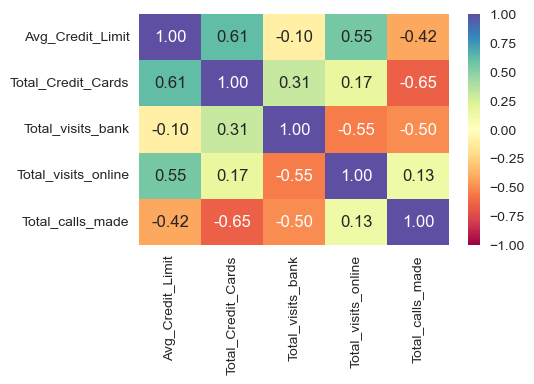

In [22]:
cor = data.corr()

plt.figure(figsize=(5, 3))
sns.heatmap(cor, vmin = -1, vmax = 1, cmap = "Spectral", annot=True, fmt=".2f")
plt.show()

**Observation**

- The Total number of credit cards is strongly positively correlated with the average card limit for each customers. This is likely so because the higher the number of credit cards owned by a customer the higher the average card limit


- The average card limit is also strongly positively correlated with the total  number of online visits or online logins made by the customer (yearly). In other words, customers who visit the bank more frequently or log in online more often are likely to have higher average credit limits.


- The total number of credit cards is slightly positively correlated with the total number of visits that customer made (yearly) personally to the bank 

### Feature Scaling

In [23]:
# scaling the dataset before clustering

scaler = StandardScaler()
data_sd = scaler.fit_transform(data)

In [24]:
data_sd

array([[ 1.72349946, -1.24708705, -0.86060646, -0.55040688, -1.24844298],
       [ 0.40020878, -0.78670054, -1.47640975,  2.49980809,  1.88123746],
       [ 0.40020878,  1.05484553, -0.86060646,  0.12741867,  0.14252611],
       ...,
       [ 2.91446107,  1.51523205, -0.86060646,  2.16089532, -0.9007007 ],
       [ 3.62903804,  2.43600508, -0.86060646,  4.19437197, -1.24844298],
       [ 3.49670897,  1.97561857, -1.47640975,  3.17763364, -0.55295843]])

In [25]:
# creating a dataframe of the scaled columns

scaled_data = pd.DataFrame(data_sd, columns = data.columns)

scaled_data


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.723499,-1.247087,-0.860606,-0.550407,-1.248443
1,0.400209,-0.786701,-1.476410,2.499808,1.881237
2,0.400209,1.054846,-0.860606,0.127419,0.142526
3,-0.129107,0.134072,-0.860606,-0.550407,0.142526
4,1.723499,0.594459,-1.476410,3.177634,-0.205216
...,...,...,...,...,...
644,1.697034,2.436005,-0.860606,2.499808,-1.248443
645,1.300046,2.436005,-0.860606,3.516546,-0.552958
646,2.914461,1.515232,-0.860606,2.160895,-0.900701
647,3.629038,2.436005,-0.860606,4.194372,-1.248443


### K-Means Clustering

In [26]:
# building the K-Means cluster model with a default of 8 clusters

kmeans = KMeans(random_state=0)

kmeans.fit( scaled_data)

KMeans(random_state=0)

In [27]:
# finding the inertia for the default number of clusters

kmeans.inertia_

551.152578895879

- The inertia for the 8 clusters is high, meaning that there is a high distance between the data points in our clusters and the centroid

In [28]:
# predicting the clusters of the customers in our data

y_pred = kmeans.predict(scaled_data)

y_pred

array([0, 1, 0, 6, 4, 1, 4, 5, 5, 1, 5, 1, 1, 5, 5, 1, 5, 5, 1, 1, 5, 1,
       5, 5, 1, 1, 1, 1, 5, 1, 5, 5, 1, 5, 1, 5, 1, 5, 1, 1, 1, 1, 5, 5,
       5, 1, 5, 5, 1, 5, 1, 5, 1, 1, 1, 5, 5, 1, 1, 1, 1, 1, 5, 5, 1, 5,
       5, 5, 1, 1, 1, 1, 5, 5, 1, 5, 5, 5, 1, 1, 1, 5, 5, 5, 5, 5, 1, 5,
       1, 1, 5, 1, 5, 1, 5, 1, 5, 5, 1, 5, 5, 1, 1, 1, 1, 1, 5, 5, 5, 1,
       5, 1, 1, 5, 5, 1, 1, 1, 5, 1, 5, 1, 5, 1, 1, 5, 1, 1, 5, 5, 5, 5,
       5, 1, 1, 5, 1, 1, 1, 1, 1, 5, 1, 5, 1, 5, 1, 5, 1, 1, 1, 5, 5, 5,
       1, 5, 1, 1, 1, 5, 1, 5, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1, 1, 5, 1,
       1, 5, 5, 1, 1, 1, 5, 5, 5, 1, 5, 5, 1, 5, 5, 1, 5, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 5, 5, 5, 5, 1, 1, 5, 5, 5, 1, 1, 5, 5, 1, 1, 1, 5, 1,
       1, 1, 5, 1, 1, 6, 6, 3, 6, 3, 6, 3, 3, 3, 3, 6, 6, 6, 3, 6, 3, 6,
       6, 3, 6, 3, 3, 6, 6, 3, 6, 6, 3, 6, 3, 6, 3, 3, 6, 3, 6, 3, 3, 3,
       3, 3, 3, 3, 6, 6, 3, 3, 6, 3, 3, 3, 3, 3, 6, 6, 6, 6, 3, 3, 6, 6,
       3, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3,

In [29]:
# checking the silhouette score for the default number of clusters

silhouette_score(scaled_data, y_pred)

0.22674118832294698

- The sihouette score is low, implying that our clusters are poorly segmented

#### Choosing optimal number of clusters

Number of Clusters: 1 	Average Distortion: 2.007896349270688
Number of Clusters: 2 	Average Distortion: 1.4576197022077821
Number of Clusters: 3 	Average Distortion: 1.1434401208195095
Number of Clusters: 4 	Average Distortion: 1.0435538595477063
Number of Clusters: 5 	Average Distortion: 0.9878677336058027
Number of Clusters: 6 	Average Distortion: 0.9401357424610066
Number of Clusters: 7 	Average Distortion: 0.907392720077748
Number of Clusters: 8 	Average Distortion: 0.883355699253853


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

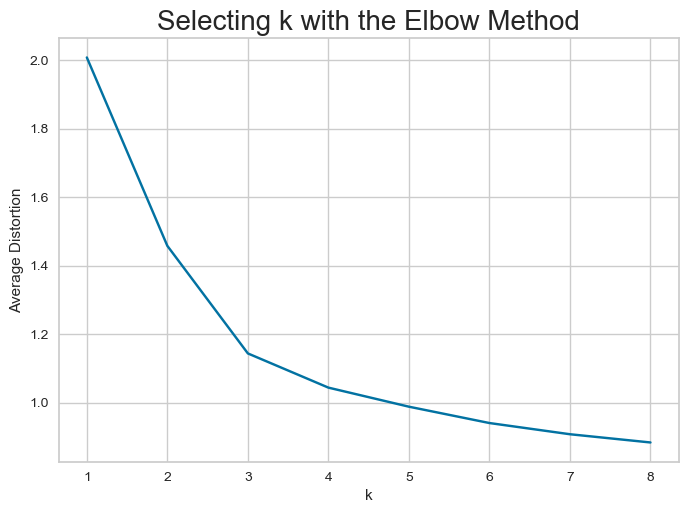

In [30]:
# Function to find the optimal number of clusters and plot elbow

clusters = range(1, 9)
meanDistortions = []  # Create a empty list

for k in clusters:
    model = KMeans(n_clusters = k)  # Initialize KMeans
    model.fit(scaled_data)  # Fit kMeans on the data
    prediction = model.predict(scaled_data)  # Predict the model on the data
    distortion = (
        sum(np.min(cdist(scaled_data, model.cluster_centers_, "euclidean"), axis=1))
        / scaled_data.shape[0]  # Find distortion
    )

    meanDistortions.append(
        distortion
    )  # Append distortion values to the empty list created above

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")  # Title of X-axis
plt.ylabel("Average Distortion")  # Title of y-axis
plt.title("Selecting k with the Elbow Method", fontsize=20)  # Title of the plot

**In the above plot, the elbow is seen at 2, 3 and 4 on the K-axis. Meaning, these values will give us optimal number of clusters** 

**To make a better decision about the number of clusters, we can look at the silhouette score for different K values.**

### Finding the best sihouette score for different K values

For n_clusters = 2, silhouette score is 0.41800025566689647
For n_clusters = 3, silhouette score is 0.516281010855363
For n_clusters = 4, silhouette score is 0.3570238219413198
For n_clusters = 5, silhouette score is 0.2731883976468857
For n_clusters = 6, silhouette score is 0.25726918996025394
For n_clusters = 7, silhouette score is 0.24838092108862636
For n_clusters = 8, silhouette score is 0.22712579590269844
For n_clusters = 9, silhouette score is 0.21418784790609033


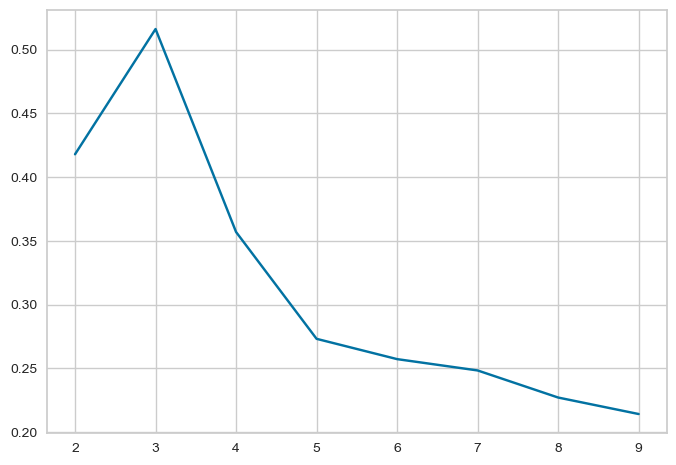

In [31]:


sil_score = []  # Create empty list
cluster_list = list(range(2, 10))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((scaled_data))  # Predicting on the data
    # centers = clusterer.cluster_centers_
    score = silhouette_score(scaled_data, preds)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, 3 is the best value of k because it has the highest value of silhouette score, 0.516**

### Applying KMeans clustering for k = 3

In [32]:
kmeans2 = KMeans(n_clusters=3, random_state=0)
kmeans2.fit(scaled_data)

KMeans(n_clusters=3, random_state=0)

In [33]:
labels = kmeans2.predict(scaled_data)

sil2 = silhouette_score(scaled_data, labels)

sil2

0.516281010855363

In [34]:
labels

array([1, 2, 1, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [35]:
# adding kmeans cluster labels to the original dataframe
scaled_data["Kmeans_clusters"] = kmeans2.labels_

In [36]:
scaled_data

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Kmeans_clusters
0,1.723499,-1.247087,-0.860606,-0.550407,-1.248443,1
1,0.400209,-0.786701,-1.476410,2.499808,1.881237,2
2,0.400209,1.054846,-0.860606,0.127419,0.142526,1
3,-0.129107,0.134072,-0.860606,-0.550407,0.142526,1
4,1.723499,0.594459,-1.476410,3.177634,-0.205216,0
...,...,...,...,...,...,...
644,1.697034,2.436005,-0.860606,2.499808,-1.248443,0
645,1.300046,2.436005,-0.860606,3.516546,-0.552958,0
646,2.914461,1.515232,-0.860606,2.160895,-0.900701,0
647,3.629038,2.436005,-0.860606,4.194372,-1.248443,0


In [37]:
num_col.append("Avg_Credit_Limit")

print(num_col)

['Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made', 'Avg_Credit_Limit']


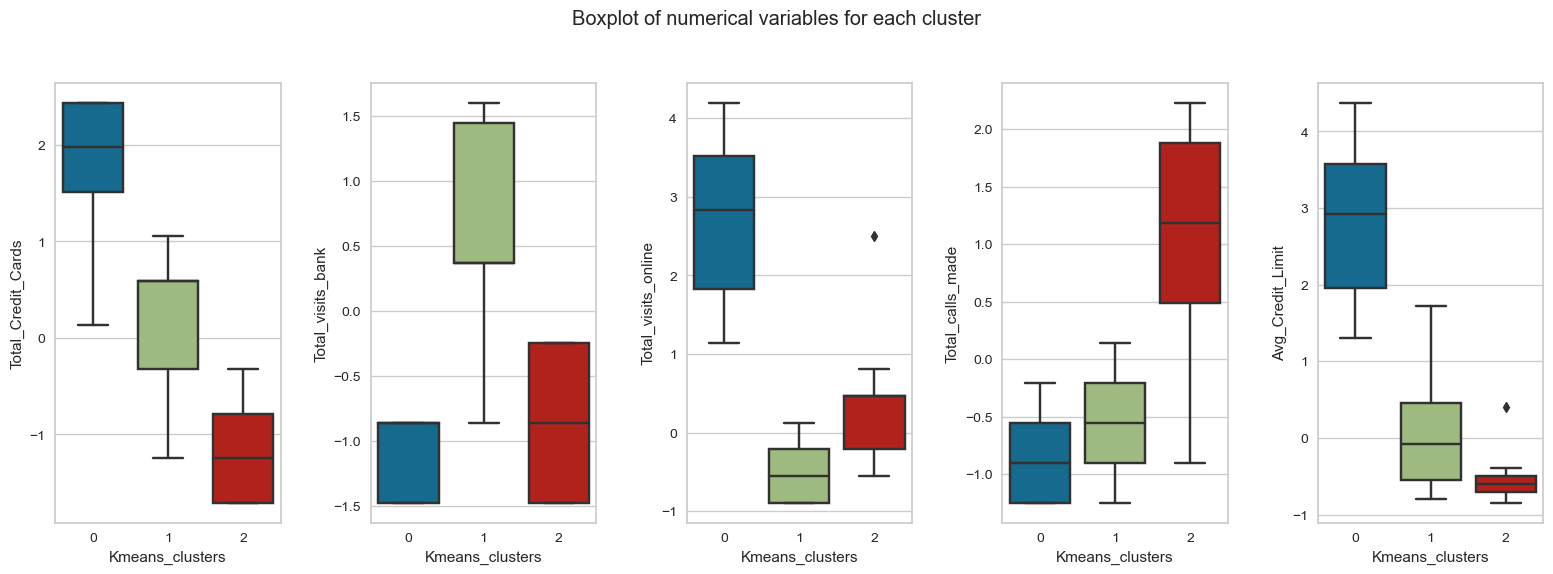

In [38]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax = axes[ii], y = scaled_data[num_col[counter]], x = scaled_data["Kmeans_clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights from K-Means Plot

- **Cluster 0**: 

  Customers in this cluster have
    - Moderate to high total credit cards
    - Low total visits to the bank .
    - Moderate to high total online logins made
    - Low total number of calls made by the customer to the bank or its customer service 
    - Moderate to high average credit limit



- **Cluster 1**: 

  Customers in this cluster have:
    - Low to moderate total credit cards
    - Low to high total visits to the bank
    - Low total online logins made
    - Low total number of calls made by the customer to the bank or its customer service 
    - Low to moderate average credit limit
    
    
    
- **Cluster 2**: 

  Customers in this cluster have:
    - Low total credit cards
    - Low to total visits to the bank.
    - Low total online logins made.
    - Low to high total number of calls made by the customer to the bank or its customer service 
    - Low average credit limit

### DBSCAN CLUSTERING

In [39]:
# Creating a variable db_data without the Kmeans cluster column

db_data = scaled_data.drop("Kmeans_clusters", axis = 1)

In [40]:
# Sanity Check

db_data

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.723499,-1.247087,-0.860606,-0.550407,-1.248443
1,0.400209,-0.786701,-1.476410,2.499808,1.881237
2,0.400209,1.054846,-0.860606,0.127419,0.142526
3,-0.129107,0.134072,-0.860606,-0.550407,0.142526
4,1.723499,0.594459,-1.476410,3.177634,-0.205216
...,...,...,...,...,...
644,1.697034,2.436005,-0.860606,2.499808,-1.248443
645,1.300046,2.436005,-0.860606,3.516546,-0.552958
646,2.914461,1.515232,-0.860606,2.160895,-0.900701
647,3.629038,2.436005,-0.860606,4.194372,-1.248443


In [41]:
# create an instance of the DBSCAN

dbscan = DBSCAN()

# fit and predict the labels

db_labels = dbscan.fit_predict(db_data)

In [42]:
# check the labels

np.unique(db_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23], dtype=int64)

There are too many clusters, so will find the optimal value of eps and minimum points and rebuild the model to get an effective number of clusters

#### Choosing optimal values of eps and minPts

In [43]:
# import itertools

import itertools

In [44]:
# trying values of eps between 0.4 and 1; minPts between 2 and 10

eps = np.linspace(0.1, 1, 10)
minPts = np.arange(2, 10)

In [45]:
# a list of eps and minPts we are going to iterate through

list(itertools.product(eps, minPts))  

[(0.1, 2),
 (0.1, 3),
 (0.1, 4),
 (0.1, 5),
 (0.1, 6),
 (0.1, 7),
 (0.1, 8),
 (0.1, 9),
 (0.2, 2),
 (0.2, 3),
 (0.2, 4),
 (0.2, 5),
 (0.2, 6),
 (0.2, 7),
 (0.2, 8),
 (0.2, 9),
 (0.30000000000000004, 2),
 (0.30000000000000004, 3),
 (0.30000000000000004, 4),
 (0.30000000000000004, 5),
 (0.30000000000000004, 6),
 (0.30000000000000004, 7),
 (0.30000000000000004, 8),
 (0.30000000000000004, 9),
 (0.4, 2),
 (0.4, 3),
 (0.4, 4),
 (0.4, 5),
 (0.4, 6),
 (0.4, 7),
 (0.4, 8),
 (0.4, 9),
 (0.5, 2),
 (0.5, 3),
 (0.5, 4),
 (0.5, 5),
 (0.5, 6),
 (0.5, 7),
 (0.5, 8),
 (0.5, 9),
 (0.6, 2),
 (0.6, 3),
 (0.6, 4),
 (0.6, 5),
 (0.6, 6),
 (0.6, 7),
 (0.6, 8),
 (0.6, 9),
 (0.7000000000000001, 2),
 (0.7000000000000001, 3),
 (0.7000000000000001, 4),
 (0.7000000000000001, 5),
 (0.7000000000000001, 6),
 (0.7000000000000001, 7),
 (0.7000000000000001, 8),
 (0.7000000000000001, 9),
 (0.8, 2),
 (0.8, 3),
 (0.8, 4),
 (0.8, 5),
 (0.8, 6),
 (0.8, 7),
 (0.8, 8),
 (0.8, 9),
 (0.9, 2),
 (0.9, 3),
 (0.9, 4),
 (0.9, 5),
 (0.

In [46]:
# create a tuple of eps and minPts using product method of itertools

hyper_list = list(itertools.product(eps, minPts))

for (eps, minPts) in hyper_list:
    dbscan = DBSCAN(eps=eps, min_samples=minPts)
    labels = dbscan.fit_predict(db_data)
    num_labels = len(np.unique(labels))

    if num_labels >= 2:
        score = silhouette_score(db_data, labels)
        print(f"eps: {eps}, minPts: {minPts}, num_labels: {num_labels}, score: {score}")
    else:
        print(f"eps: {eps}, minPts: {minPts}, num_labels: {num_labels} (Skipped silhouette score calculation)")


eps: 0.1, minPts: 2, num_labels: 50, score: -0.4103135264661649
eps: 0.1, minPts: 3, num_labels: 6, score: -0.45843023062686916
eps: 0.1, minPts: 4, num_labels: 1 (Skipped silhouette score calculation)
eps: 0.1, minPts: 5, num_labels: 1 (Skipped silhouette score calculation)
eps: 0.1, minPts: 6, num_labels: 1 (Skipped silhouette score calculation)
eps: 0.1, minPts: 7, num_labels: 1 (Skipped silhouette score calculation)
eps: 0.1, minPts: 8, num_labels: 1 (Skipped silhouette score calculation)
eps: 0.1, minPts: 9, num_labels: 1 (Skipped silhouette score calculation)
eps: 0.2, minPts: 2, num_labels: 83, score: -0.27402439322356437
eps: 0.2, minPts: 3, num_labels: 19, score: -0.4652936436382976
eps: 0.2, minPts: 4, num_labels: 3, score: 0.009886095986018337
eps: 0.2, minPts: 5, num_labels: 1 (Skipped silhouette score calculation)
eps: 0.2, minPts: 6, num_labels: 1 (Skipped silhouette score calculation)
eps: 0.2, minPts: 7, num_labels: 1 (Skipped silhouette score calculation)
eps: 0.2, min

We are going to pick eps 1.0 and minPts 3 since it gave us a high silhouette score of 0.52689

#### Implementing DBSCAN across the different hyperparameters

In [47]:
# rebuild the model

dbscan2 = DBSCAN(eps = 1.0, min_samples = 3) 

db_labels2 = dbscan2.fit_predict(db_data)

In [48]:
# check unique labels

np.unique(db_labels2)

array([-1,  0,  1], dtype=int64)

So we have 3 groups. One group of outliers,-1, 0 and 1

In [49]:
# add the dbscan labels to the original data

db_data["db_labels"] = db_labels2

In [50]:
# Sanity check

db_data.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,db_labels
0,1.723499,-1.247087,-0.860606,-0.550407,-1.248443,-1
1,0.400209,-0.786701,-1.476410,2.499808,1.881237,-1
2,0.400209,1.054846,-0.860606,0.127419,0.142526,0
3,-0.129107,0.134072,-0.860606,-0.550407,0.142526,0
4,1.723499,0.594459,-1.476410,3.177634,-0.205216,1


### Visualizing groups

In [51]:
db_data.columns

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made', 'db_labels'],
      dtype='object')

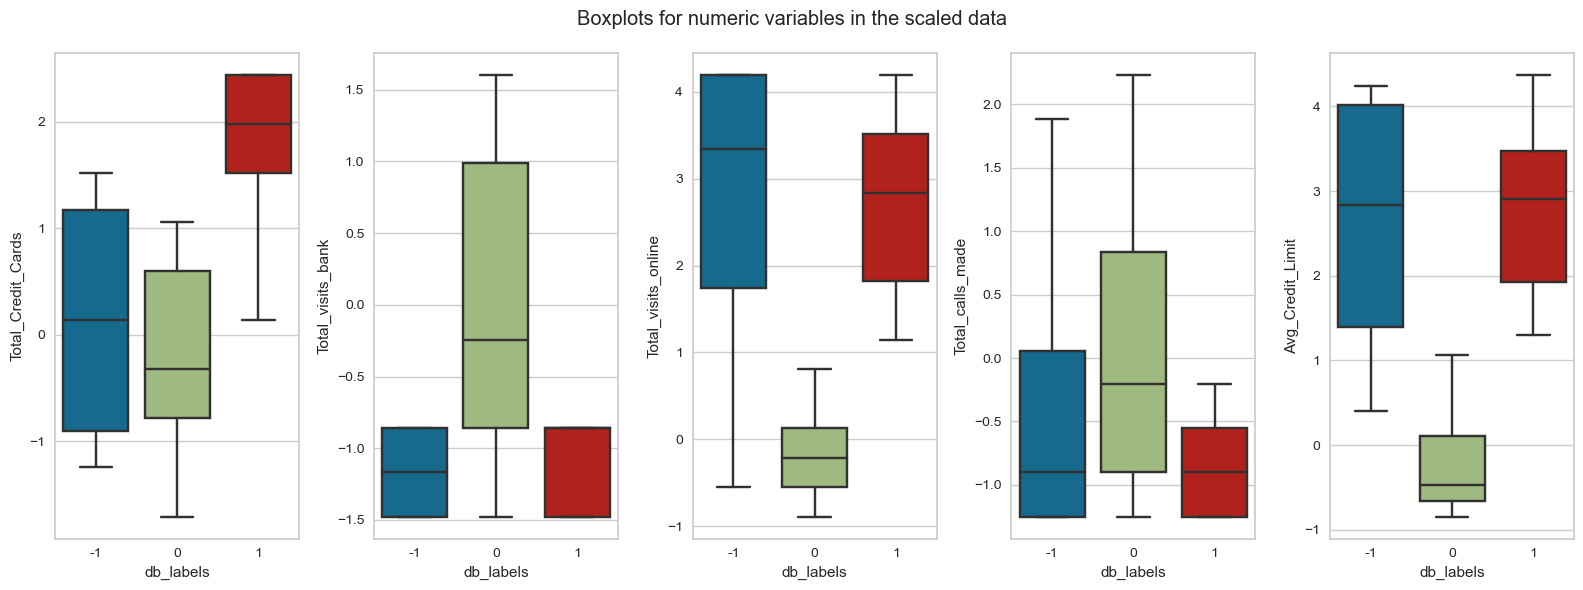

In [52]:
# examine same in the original variables

fig, ax = plt.subplots(1, 5, figsize = (16, 6))
fig.suptitle("Boxplots for numeric variables in the scaled data")

count = 0
for i in range(5):
    sns.boxplot(ax = ax[i], x = db_data["db_labels"], y = db_data[num_col[count]])
    count += 1
fig.tight_layout()

### Insight from DBSCAN plot

- **Cluster -1**: 

  Customers in this cluster have
    - low to moderate total credit cards
    - Low total visits to the bank .
    - High total online logins made
    - Low total number of calls made by the customer to the bank or its customer service 
    - Moderate to high average credit limit



- **Cluster 0**: 

  Customers in this cluster have:
    - Low to moderate total credit cards
    - Low to high total visits to the bank
    - Low total online logins made
    - Low to high total number of calls made by the customer to the bank or its customer service 
    - Low average credit limit
    
    
    
- **Cluster 1**: 

  Customers in this cluster have:
    - High total credit cards
    - Low total visits to the bank.
    - High total online logins made.
    - Low total number of calls made by the customer to the bank or its customer service 
    - High average credit limit

### K-MEANS VS DBSCAN Clustering

From the observations obtained from the K-means and DBSCAN clustering technique:

- **Cluster 0** in K-means corresponds to **Cluster 2** in DBSCAN. Both clusters have similar characteristics such as low total credit cards, low total visits to the bank, low total online logins, low to high total number of calls made, and low average credit limit.


- **Cluster 1** in K-means corresponds to **Cluster 1** in DBSCAN. These clusters share similarities such as low to moderate total credit cards, low to high total visits to the bank, low total online logins, low to high total number of calls made, and low average credit limit.



- **Cluster 2** in K-means corresponds to **Cluster 0** in DBSCAN. These clusters exhibit similar traits, including moderate to high total credit cards, low total visits to the bank, moderate to high total online logins, low total number of calls made, and moderate to high average credit limit.



### Business Recommendations

Based on the observations from the K-means and DBSCAN clustering techniques, we can draw some key takeaways for the business. Here are the recommendations:



1. **Key Takeaways for the Business:**


   - Both clustering techniques identified similar patterns in terms of the relationship between different attributes and customer segments.
   
   
   - Customers in Cluster 0 (K-means) and Cluster 1 (DBSCAN) have lower credit card usage, more visits to the bank, lower online logins, fewer calls, and lower average credit limits. 
   
   
   - Customers in Cluster 2 (K-means) and Cluster -1 (DBSCAN outliers) have lower credit card usage, fewer visits to the bank, lower online logins, higher number of calls, and lower average credit limits. 
   
   
   - Customers in Cluster 1 (K-means) and Cluster 1 (DBSCAN) have higher credit card usage, lower visits to the bank, higher online logins, fewer calls, and higher average credit limits. 
   
   
   
2. **Recommendations to the Business:**


   - For customers in Cluster 0 (K-means) and Cluster 1 (DBSCAN), the business can focus on targeted marketing campaigns to increase credit card usage. This could include personalized offers, rewards programs, and incentives to encourage these customers to use their credit cards more frequently.
   
   
   - For customers in Cluster 2 (K-means) and Cluster -1 (DBSCAN outliers), the business should prioritize improving customer support services. This could involve streamlining the query resolution process, providing faster responses, and ensuring a seamless customer experience across different channels.
   
   
   - For customers in Cluster 1 (K-means) and Cluster 1 (DBSCAN), the business can explore upselling and cross-selling opportunities. This could involve recommending higher credit limits, offering premium credit card options, and providing tailored financial products and services to cater to their financial needs.
   
   
   - Regular monitoring of customer segments and analysis of their evolving needs and preferences can help the business refine its marketing strategies, improve customer satisfaction, and drive overall business growth.

